In [1]:
# Code for generating the figure for the Toliman paper
# Want to create spectrum of just one of the alpha cens (perhaps alpha cen A)
# propagate it through my sidelobe code
# recover the spectrum through gradient descent.

# first, begin with the tutorial on generating the spectrum: https://github.com/maxecharles/dLuxToliman/blob/main/photon_count.md

import matplotlib.pyplot as plt
import jax.numpy as np
import pysynphot as S
import os
from pandas import read_csv
from scipy.interpolate import interp1d
import dLux as dl
import dLuxToliman as dlT
# first problem, can't really import pysynphot, had to change np all true to np all.
# set parameters

ALPHA_CEN_A_SURFACE_TEMP = 5790.0  # K
ALPHA_CEN_A_METALICITY = 0.2
ALPHA_CEN_A_SURFACE_GRAV = 4.0  # log(g)
ALPHA_CEN_A_MAGNITUDE = 0.01  # vega magnitude

ALPHA_CEN_B_SURFACE_TEMP = 5260.0  # K
ALPHA_CEN_B_METALICITY = 0.23
ALPHA_CEN_B_SURFACE_GRAV = 4.37  # log(g)
ALPHA_CEN_B_MAGNITUDE = 1.33  # vega magnitude

# changing working directory so pysynphot can find the data
os.chdir("/Users/milolangker/data/pysynphot/")

/Users/milolangker/anaconda3/envs/localToliman/lib/python3.12/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/milolangker/anaconda3/envs/localToliman/lib/python3.12/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
primary = np.pi * (12.5**2 - 3.2**2)

S.setref(
    graphtable="mtab/83816517m_tmg.fits",
    comptable="mtab/8a31932bm_tmc.fits",
    thermtable="mtab/3241637sm_tmt.fits",
    area=primary,  # not sure that this actually does anyting tbh
)

print(f"TOLIMAN Primary Area: {primary:.2f} square cm.")

TOLIMAN Primary Area: 458.70 square cm.


In [3]:
A_sp = S.Icat(
    "phoenix",
    ALPHA_CEN_A_SURFACE_TEMP,
    ALPHA_CEN_A_METALICITY,
    ALPHA_CEN_A_SURFACE_GRAV,
)

B_sp = S.Icat(
    "phoenix",
    ALPHA_CEN_B_SURFACE_TEMP,
    ALPHA_CEN_B_METALICITY,
    ALPHA_CEN_B_SURFACE_GRAV,
)

# Renormalising to respective magnitudes
VBand = S.ObsBandpass("v")
A_sp = A_sp.renorm(RNval=ALPHA_CEN_A_MAGNITUDE, RNUnits="vegamag", band=VBand)
B_sp = B_sp.renorm(RNval=ALPHA_CEN_B_MAGNITUDE, RNUnits="vegamag", band=VBand)

# Converting units
A_sp.convert("Photlam")
B_sp.convert("Photlam")

sum_sp = A_sp.flux + B_sp.flux

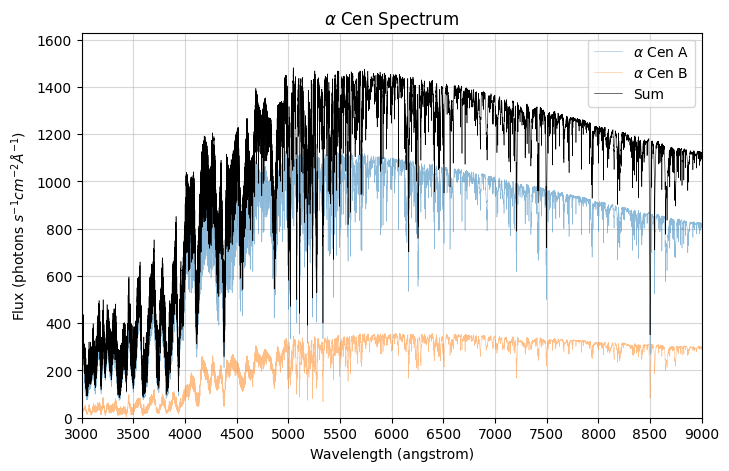

In [4]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(A_sp.wave, A_sp.flux, label=r"$\alpha$ Cen A", alpha=0.5, lw=0.4)
ax.plot(B_sp.wave, B_sp.flux, label=r"$\alpha$ Cen B", alpha=0.5, lw=0.4)
ax.plot(A_sp.wave, sum_sp, label="Sum", c="k", lw=0.4)
ax.set(
    title=r"$\alpha$ Cen Spectrum",
    xlabel=f"Wavelength ({A_sp.waveunits})",
    ylabel=r"Flux (photons $s^{-1}cm^{-2}\AA^{-1}$)",
    xlim=(3000, 9000),
    xticks=np.linspace(3000, 9000, 13),
    ylim=(0, sum_sp.max() * 1.1),
)
ax.grid(alpha=0.5)
ax.legend()
plt.show()

In [5]:
# while in reality we would certainly

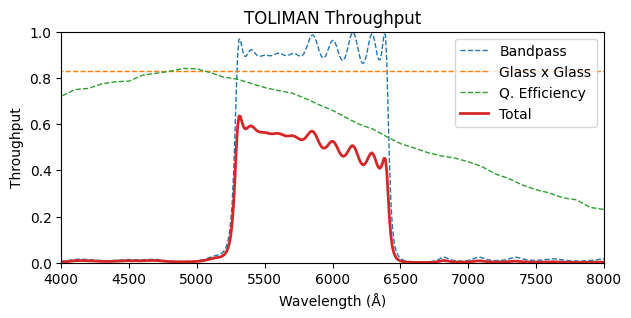

In [6]:
# bandpass, wavelength (nm) and throughput (%)
bp = read_csv("bandpass.csv")
# labelling columns
bp.columns.values[1] = 'Throughput'
bp.columns.values[0] = 'Wavelength'

bp_tp = bp.Throughput / 100
wavels = 10 * np.array(bp.Wavelength)  # angstrom, canonical wavelength grid

# approximate transmission factor of ONE sheet of glass
glass = 0.91  # this is a visual estimation from a piece of paper
glass_tp = glass * glass * np.ones_like(wavels)  # TWICE for two sheets

# quantum efficiency, wavelength (nm) and QE (%)
qe = read_csv("qe.csv")

# labelling columns
qe.columns.values[1] = 'QE'
qe.columns.values[0] = 'Wavelength'

# We want to interpolate the QE data to the bandpass data
interp_func = interp1d(
    10 * qe.Wavelength, qe.QE / 100, kind="linear", bounds_error=False, fill_value=0
)
qe_tp = interp_func(wavels)

# Combine the bandpass, glass and QE data
total_bp = bp_tp * glass_tp * qe_tp

fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(wavels, bp_tp, label="Bandpass", linestyle="--", linewidth=1)
ax.plot(wavels, glass_tp, label="Glass x Glass", linestyle="--", linewidth=1)
ax.plot(wavels, qe_tp, label="Q. Efficiency", linestyle="--", linewidth=1)
ax.plot(wavels, total_bp, label="Total", linewidth=2)
ax.set(
    ylim=(0, 1.0),
    xlim=(4000, 8000),
    xlabel=f"Wavelength (Å)",
    ylabel="Throughput",
    title="TOLIMAN Throughput",
)
ax.legend(loc="upper right")
plt.show()

In [7]:
# creating pysynphot bandpass object
bandpass = S.ArrayBandpass(wavels, total_bp, waveunits="angstrom")

# creating observation objects
A_obs = S.Observation(A_sp, bandpass)
B_obs = S.Observation(B_sp, bandpass)
sum_obs = A_obs.flux + B_obs.flux

(UnnamedArrayBandpass) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(UnnamedArrayBandpass) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


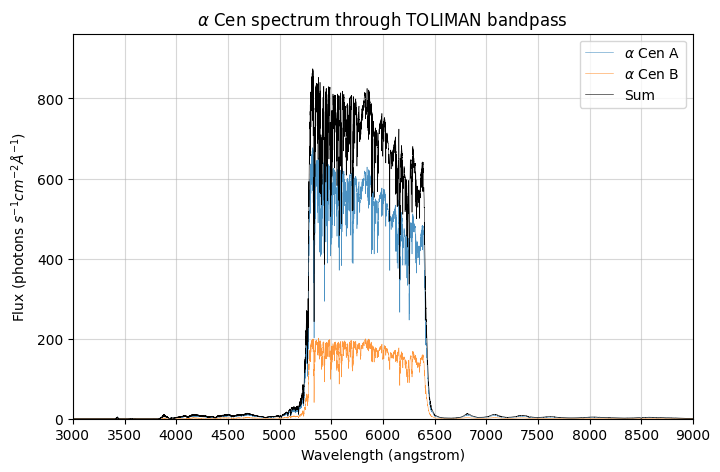

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(A_obs.wave, A_obs.flux, label=r"$\alpha$ Cen A", alpha=0.8, lw=0.4)
ax.plot(B_obs.wave, B_obs.flux, label=r"$\alpha$ Cen B", alpha=0.8, lw=0.4)
ax.plot(A_obs.wave, sum_obs, label="Sum", c="k", lw=0.4)
ax.set(
    title=r"$\alpha$ Cen spectrum through TOLIMAN bandpass",
    xlabel=f"Wavelength ({A_obs.waveunits})",
    ylabel=r"Flux (photons $s^{-1}cm^{-2}\AA^{-1}$)",
    xlim=(3000, 9000),
    xticks=np.linspace(3000, 9000, 13),
    ylim=(0, sum_obs.max() * 1.1),
)
ax.grid(alpha=0.5)
ax.legend()
plt.show()

In [16]:
# saving the spectra to csv
import pandas as pd
# Create a DataFrame with wavelengths and fluxes
df_A = pd.DataFrame({
    "wavelength": A_obs.wave,
    "flux": A_obs.flux
})

# Save to CSV
df_A.to_csv("alpha_cen_A_spectrum.csv", index=False)

df_B = pd.DataFrame({
    "wavelength": B_obs.wave,
    "flux": B_obs.flux
})
df_B.to_csv("alpha_cen_B_spectrum.csv", index=False)

df_sum = pd.DataFrame({
    "wavelength": A_obs.wave,
    "flux": sum_obs
})
df_sum.to_csv("alpha_cen_sum_spectrum.csv", index=False)

In [9]:
# need total flux from alpha cen A (just A)
countrate = A_obs.integrate() + B_obs.integrate()
print(
    f"Alpha Cen A: {A_obs.integrate():.3e} photons/s/cm/cm; {A_obs.integrate()*primary:.3e} photons/s"
)
print(
    f"Alpha Cen B: {B_obs.integrate():.3e} photons/s/cm/cm; {B_obs.integrate()*primary:.3e} photons/s"
)
print(
    f"Total count rate: {countrate:.3e} photons/s/cm/cm; {countrate*primary:.3e} photons/s"
)

Alpha Cen A: 6.342e+05 photons/s/cm/cm; 2.909e+08 photons/s
Alpha Cen B: 1.967e+05 photons/s/cm/cm; 9.023e+07 photons/s
Total count rate: 8.309e+05 photons/s/cm/cm; 3.811e+08 photons/s


In [10]:
exp_time = 0.1  # seconds

tot_phot = countrate * primary * exp_time
alpha_a_phot = A_obs.integrate() * primary * exp_time
print(f"Total photons in {exp_time} seconds: {tot_phot:.3e} photons")
print(f"Alpha Cen A photons in {exp_time} seconds: {alpha_a_phot:.3e} photons")
print(f"Log10 of total photons: {np.log10(tot_phot):.3f}")

Total photons in 0.1 seconds: 3.811e+07 photons
Alpha Cen A photons in 0.1 seconds: 2.909e+07 photons
Log10 of total photons: 7.581


In [11]:
# While this will eventually be needed, not necessary for us

In [12]:
# Great. Now we can use this spectra from Alpha Cen A, apply it to a point source, then propagate it with dlux
import dLux as dl
import dLuxToliman as dlT

PointSource(
  spectrum=Spectrum(wavelengths=f32[200], weights=f32[200]),
  position=f32[2],
  flux=1000000000000.0
)


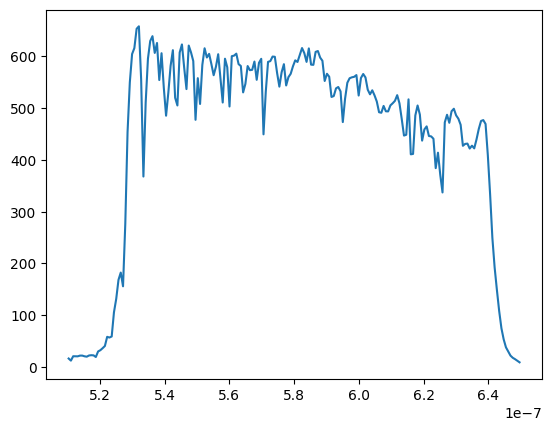

In [13]:
# define our wavelengths and weights, with a cutoff mask
mask = (A_obs.wave >= 5100) & (A_obs.wave <= 6500)
wavelengths = A_obs.wave[mask] * 10**(-10) # meters
weights = A_obs.flux[mask] # these weights will be normalised by the point source stuff
# now create the source. just gonna make flux 10**6 photons
# gives nearly 4000 wavelengths. this is a crazy amount. perhaps we should downsample.
# infact, it would take like way to long to model. I'm gonna downsample

from scipy.stats import binned_statistic

# Number of bins
n_bins = 200

# Bin wavelengths and compute mean flux in each bin
bin_means, bin_edges, _ = binned_statistic(
    wavelengths, weights, statistic='mean', bins=n_bins
)

# Compute bin centers for the x-axis
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
alpha_cen_a_source = dl.PointSource(wavelengths = bin_centers, weights = bin_means, flux = 10**12)

print(alpha_cen_a_source)
plt.plot(bin_centers, bin_means)
plt.show()

In [15]:
# now, generate the optics to propagate
import dLux.utils as dlu
# constructing the telescope:
wf_npixels = 256 # nice and low res
diameter = 0.125
period = 304e-6
difference = np.pi * 0.348

apertureLayer = dlT.TolimanApertureLayer(wf_npixels)

layers = [
    (
        'aperture',
        apertureLayer
    )
]

psf_npixels = 128
pixel_scale = 1
oversample = 4 # high level oversample

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,pixel_scale,oversample)

In [16]:
telescope = dl.Telescope(optics, alpha_cen_a_source)
sidelobescope = dlT.SideLobeTelescope(telescope, period, difference)

In [17]:
center_wl = 585e-9
sidelobes = sidelobescope.model_sidelobes(float(center_wl))

# great. need to perform gradient descent on this system.

Model time: 4.5060 seconds.


In [18]:
weights_path = 'telescope.source.spectrum.weights'
model = sidelobescope.set(weights_path, np.ones(n_bins)/n_bins)
#print(model)
model_psf = model.model_sidelobes(float(center_wl))

Model time: 3.0140 seconds.


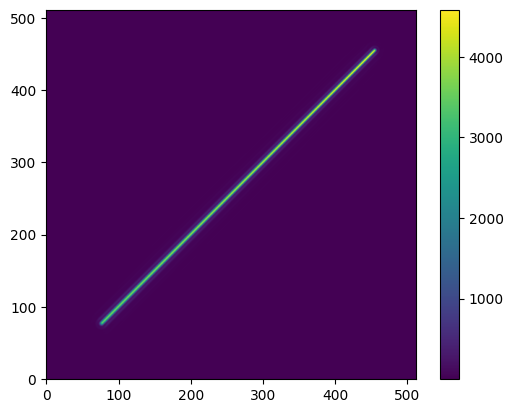

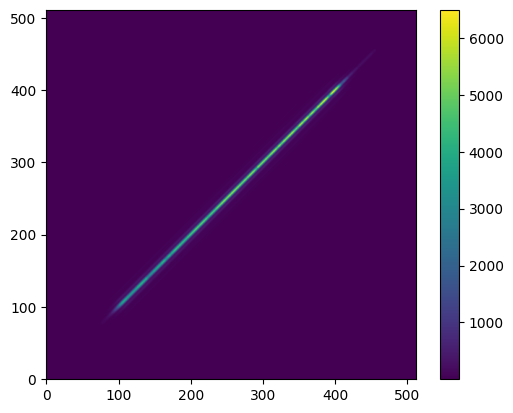

In [19]:
plt.imshow(model_psf,origin='lower')
plt.colorbar()
plt.show()
plt.imshow(sidelobes,origin='lower')
plt.colorbar()
plt.show()

In [20]:
# Core jax
import jax
import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

weights_optimiser = optax.adam(1e-4)

optim, opt_state = zdx.get_optimiser(model, weights_path, weights_optimiser)

In [21]:
out = model.model_sidelobes(float(center_wl))

Model time: 3.9159 seconds.


In [22]:
print(sidelobes - out)

[[-0.07073545 -0.07866427 -0.08525045 ...  0.00592218  0.0056886
   0.00521812]
 [-0.06701132 -0.07526369 -0.08020439 ...  0.00598407  0.00579136
   0.00544972]
 [-0.06375702 -0.06803344 -0.07074775 ...  0.00573995  0.00570828
   0.0055478 ]
 ...
 [ 0.00431727  0.00402132  0.00373117 ... -0.1954413  -0.15973096
  -0.13412818]
 [ 0.0044473   0.00419113  0.00399419 ... -0.1828824  -0.15644862
  -0.1498658 ]
 [ 0.0044559   0.00438202  0.00430201 ... -0.16859606 -0.1672768
  -0.17028347]]


In [23]:
@zdx.filter_jit
@zdx.filter_value_and_grad(weights_path)
def loss_fn(model, data):
    out = model.model_sidelobes(center_wl)
    return np.sum((data - out)**2)

In [24]:
%%time
loss, grads = loss_fn(model, sidelobes) # Compile
print("Initial Loss: {}".format(int(loss)))


Model time: 3.1629 seconds.
Initial Loss: 5085457408
CPU times: user 6min 11s, sys: 3.81 s, total: 6min 14s
Wall time: 3min 1s


In [25]:
from tqdm import tqdm

In [26]:
losses, models_out = [], []
with tqdm(range(100),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_fn(model, sidelobes)    
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)
        model = model.set(weights_path, np.maximum(np.zeros(n_bins),model.telescope.source.spectrum.weights))
        losses.append(loss)
        models_out.append(model)
        t.set_description("Log Loss: {:.3f}".format(np.log10(loss))) # update the progress bar

Log Loss: 5.247: 100%|██████████| 100/100 [20:59<00:00, 12.60s/it]


Model time: 3.6001 seconds.


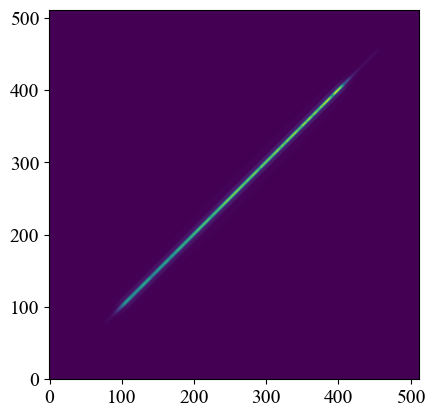

In [29]:
plt.imshow(models_out[99].model_sidelobes(center_wl), origin='lower')
plt.show()

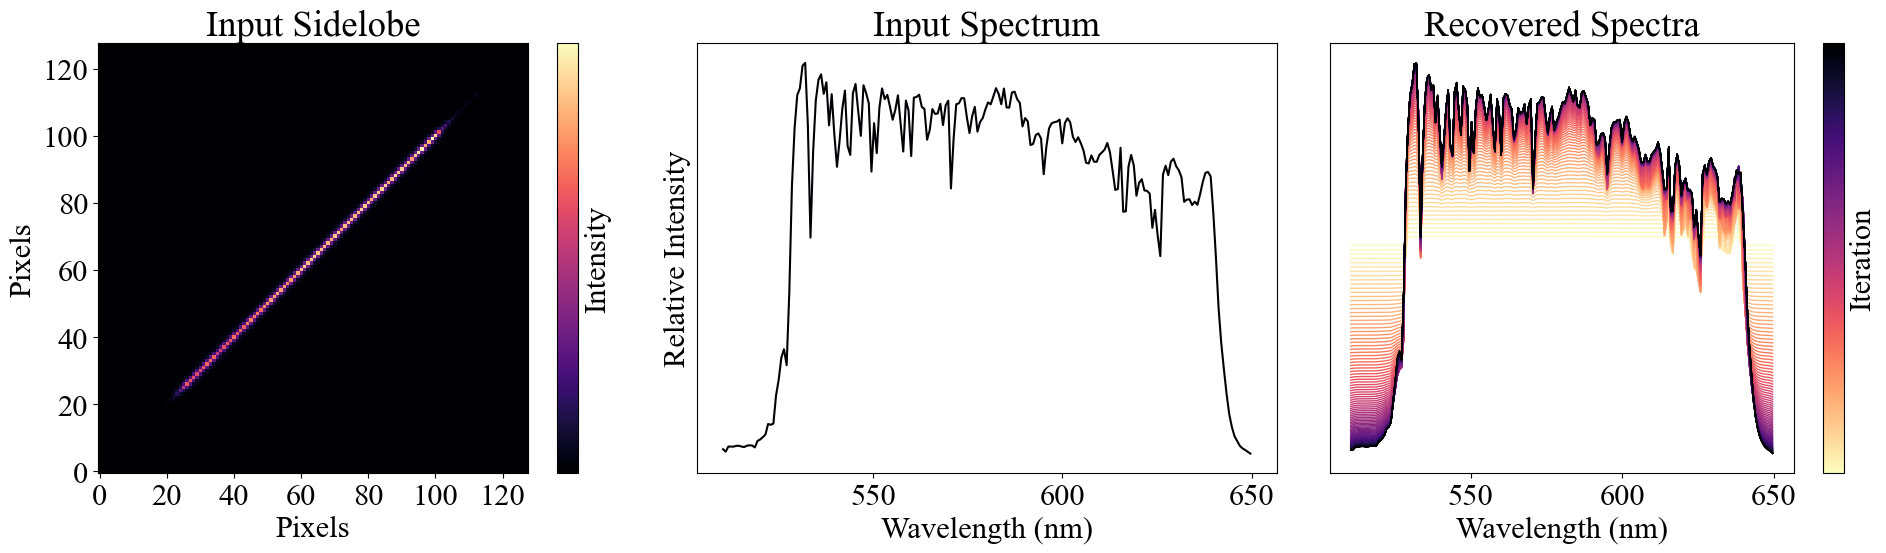

In [113]:
import matplotlib.colors as colors
import matplotlib.cm as cm
# Times new Roman font
plt.rcParams["font.family"] = "Times New Roman"
#plt.rcParams['text.usetex'] = True

# Single font size
plt.rcParams["font.size"] = 22

cmap = plt.get_cmap('magma')

plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.imshow(dlu.downsample(sidelobes,4),origin='lower',cmap=cmap)
plt.title('Input Sidelobe')
plt.xlabel('Pixels')
plt.ylabel('Pixels')

tick_spacing = 20  # Change this to the spacing you want
image_shape = dlu.downsample(sidelobes, 4).shape

plt.xticks(np.arange(0, image_shape[1], tick_spacing))
plt.yticks(np.arange(0, image_shape[0], tick_spacing))

cbar = plt.colorbar()
cbar.set_ticks([])              # remove tick marks and labels
cbar.ax.set_ylabel('Intensity') 

plt.subplot(1,3,2)
plt.plot(bin_centers*10**9,sidelobescope.telescope.source.spectrum.weights, color=cmap(1))
plt.gca().tick_params(axis='y', left=False, labelleft=False)  # remove y-axis ticks again
plt.xlabel("Wavelength (nm)")
plt.title("Input Spectrum")
plt.ylabel('Relative Intensity')

norm = colors.Normalize(vmin=0, vmax=99)  # Normalize iteration range

plt.subplot(1,3,3)

for i in range(100):
    output_weights = models_out[i].telescope.source.spectrum.weights
    color = cmap(1- i / 99) # get RGB
    alpha = 1
    plt.plot(bin_centers*10**9,output_weights, color=color, alpha=alpha, linewidth=1)  # label every 10th for readability

plt.gca().tick_params(axis='y', left=False, labelleft=False)  # remove y-axis ticks again
plt.xlabel("Wavelength (nm)")
plt.title("Recovered Spectra")

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy data
cbar = plt.colorbar(sm, ax=plt.gca(), label="Iteration")
cbar.ax.invert_yaxis()
cbar.set_ticks([])      

plt.tight_layout()
#plt.savefig('spectrum_magma_iterations.pdf',dpi=300,bbox_inches='tight')
plt.show()


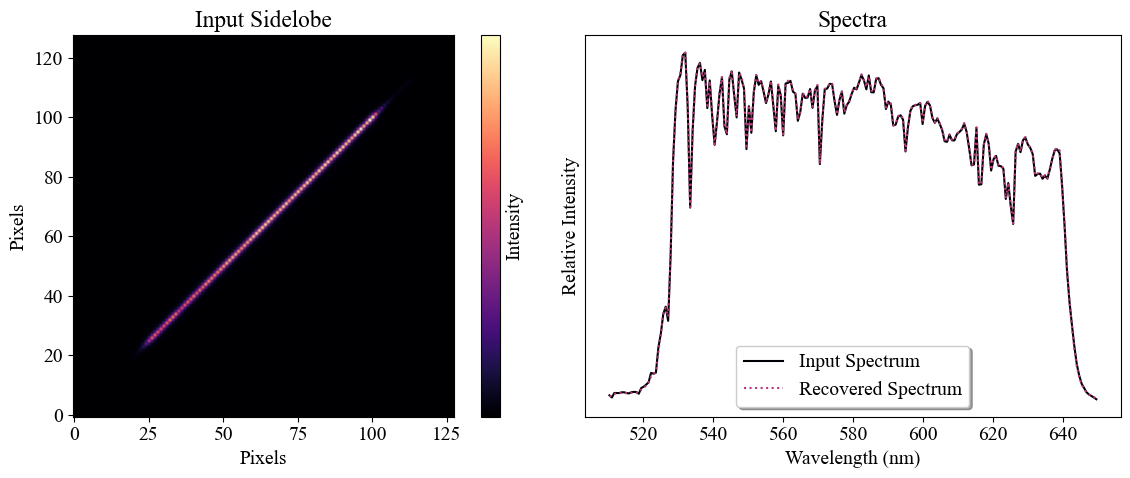

In [97]:
# Times new Roman font
plt.rcParams["font.family"] = "Times New Roman"
#plt.rcParams['text.usetex'] = True

# Single font size
plt.rcParams["font.size"] = 14

cmap = plt.get_cmap('magma')

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(dlu.downsample(sidelobes,4),origin='lower',cmap=cmap)
plt.title('Input Sidelobe')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
cbar = plt.colorbar()
cbar.set_ticks([])              # remove tick marks and labels
cbar.ax.set_ylabel('Intensity') 

plt.subplot(1,2,2)
it = 99
plt.plot(bin_centers*10**9,sidelobescope.telescope.source.spectrum.weights/np.max(sidelobescope.telescope.source.spectrum.weights), color=cmap(0),label='Input Spectrum')
plt.plot(bin_centers*10**9,models_out[it].telescope.source.spectrum.weights/np.max(models_out[it].telescope.source.spectrum.weights), color=cmap(0.5), linestyle=':',label='Recovered Spectrum')
plt.gca().tick_params(axis='y', left=False, labelleft=False)  # remove y-axis ticks again
plt.xlabel("Wavelength (nm)")
plt.title("Spectra")
plt.ylabel('Relative Intensity')
plt.legend(shadow=True)


plt.tight_layout()
plt.savefig('spectrum2_magma.pdf',dpi=300,bbox_inches='tight')
plt.show()


0.0010851327


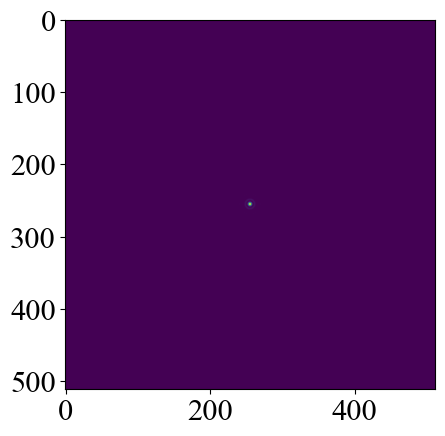

In [233]:
# just testing flux propagation.
new_single_source = dl.PointSource(wavelengths = np.array([585*10**(-9)]),flux=100,weights = np.array([1]))
new_single_psf = optics.model(new_single_source)
plt.imshow(new_single_psf)
print(np.sum(new_single_psf))
#hmm... so flux doesn't just give the total image output flux. this is interesting/annoying.

0.0010840602
4.8013313e-05
103.59266690374702
102400
988.4869562740847


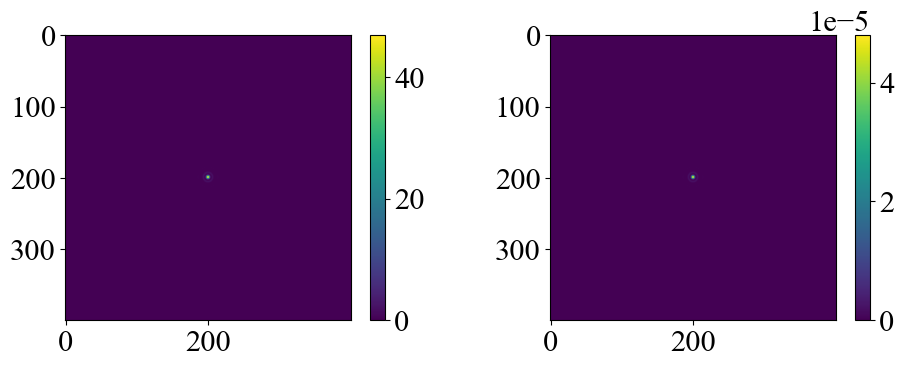

0.108406015
46.914116


In [236]:
new_psf_npixels = 100
oversample_new = 4
optics_new = dl.AngularOpticalSystem(wf_npixels,diameter,layers,new_psf_npixels,pixel_scale,oversample_new)
new_single_psf_2 = optics_new.model(new_single_source)

print(np.sum(new_single_psf_2))
print(np.max(new_single_psf_2))
# ok so clearly flux is like some 'total flux' parameter.
# because when I change the size of my output the total flux changes.
# but the peak power stays the same
# question is: how is it normalised.
# perhaps try matrix fourier transform paper, it might have a clue.
# indeed, normalisation coefficient m/N_a * N_b where m = image plane size in lambda/D
# let's see if we can get total flux from that:
#print(np.sum(new_single_psf_2) * (new_psf_npixels*oversample * wf_npixels)/(dlu.arcsec2rad(pixel_scale*new_psf_npixels) /((585*10**(-9))/diameter)))
# no. fringes function:
# fringe size:
#print((585*10**(-9))/diameter)

# radians in thingie:
#print(dlu.arcsec2rad(pixel_scale*new_psf_npixels))

# no fringes: 
no_fringes = dlu.arcsec2rad(pixel_scale*new_psf_npixels) / ((585*10**(-9))/diameter)
print(no_fringes)

# i.e. roughly 20.71 fringes.
# now, na * nb = 
na_nb = wf_npixels * new_psf_npixels*oversample_new
print(na_nb)

print(na_nb/no_fringes)
# i.e. 20480.
#print(np.sum(na_nb/no_fringes*new_single_psf_2))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow((na_nb/no_fringes)**2*(new_single_psf_2))
plt.colorbar()
# first plot peaks dont seem to change much.

plt.subplot(1,2,2)
plt.imshow((new_single_psf_2))
plt.colorbar()
plt.tight_layout()
plt.show()

print(np.sum(new_single_psf_2)*new_psf_npixels)
print(np.max((na_nb/no_fringes)**2*(new_single_psf_2)))

In [ ]:
# reading through code, it seems like flux of a point source is modelled in the following way:
# optics.model(point source (with certain flux))
# that goes to source.model
# source.model normalises the weights 
# then multiplies each weight by the flux
# to get the flux per wavelength. it calls this from now on 'weights' which really also encode flux information.
# which goes to optics.propagate
# which goes to self (in our case angular optical system). propagate_mono, and multiplies that result by the sqrt of the weight.
# self.propagate mono goes to wavefront dot propagate
# which does the matrix fourier transform of input wavefront (I assume its normalised?)
# this matrix fourier transform does it according to the paper (pretty much)
# and returns it according to m/NaNb as before.
# then for returning psf it just magnitude squares it.

# NOTE: that the psf returns in units: no. of photons. so the sum of all values on my psf should equal input flux.
# and yet I can't seem to make it so.

# I feel like there's just some sort of bug. 1 unit of flux should equal 1 photon, yet when summing up all my values i get stagnant
# 1e-5 photons.

In [246]:
(na_nb/no_fringes)

988.4869562740847

In [243]:
newLayer = dl.TransmissiveLayer(apertureLayer.transmission, True)
newLayers = [
    (
        'aperture',
        newLayer
    )
]


In [255]:
# newer optical system.. normalise = true. That was the issue. bloody heck!
new_single_source = dl.PointSource(wavelengths = np.array([585*10**(-9)]),flux=100,weights = np.array([1]))
new_psf_npixels = 10
oversample_new = 10
optics_newER = dl.AngularOpticalSystem(wf_npixels,diameter,newLayers,new_psf_npixels,pixel_scale,oversample_new)
newER_psf = optics_newER.model(new_single_source)


print(np.sum(newER_psf))


93.76692


In [256]:
# gonna save all my data so I can finally close this doc rofl

import pickle

# Save sidelobes (original, not downsampled)
np.save("sidelobes.npy", sidelobes)

# Save bin_centers (in meters, as in original code)
np.save("bin_centers.npy", bin_centers)

# Save input spectrum weights
np.save("input_weights.npy", sidelobescope.telescope.source.spectrum.weights)

# Save model outputs: 100 arrays of weights
output_weights_list = [model.telescope.source.spectrum.weights for model in models_out]
with open("output_weights.pkl", "wb") as f:
    pickle.dump(output_weights_list, f)


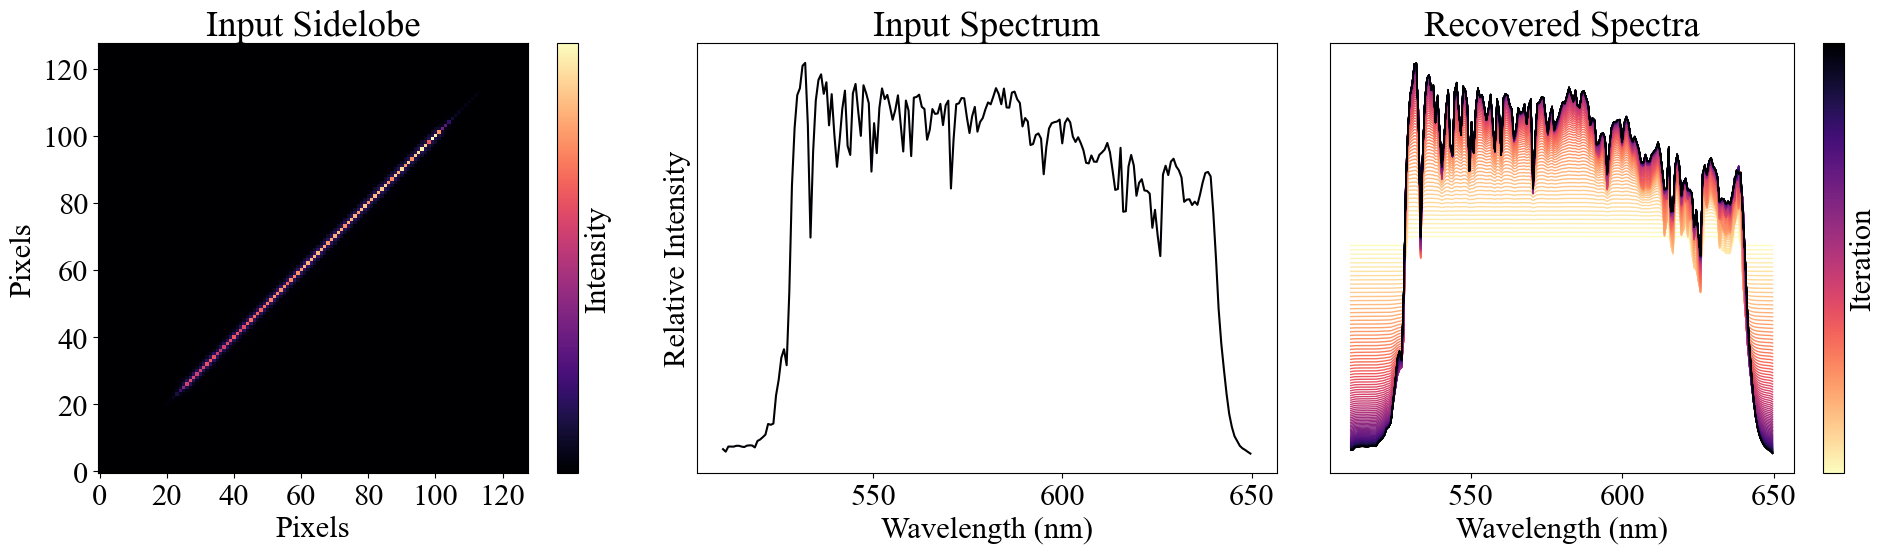

In [257]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import pickle

# Load saved data
sidelobes = np.load("sidelobes.npy")
bin_centers = np.load("bin_centers.npy")
input_weights = np.load("input_weights.npy")
with open("output_weights.pkl", "rb") as f:
    output_weights_list = pickle.load(f)

# Downsample function (mock version – replace with your actual `dlu.downsample`)
def downsample(arr, factor):
    return arr[::factor, ::factor]

# Set plot style
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 22

cmap = plt.get_cmap('magma')

plt.figure(figsize=(20, 6))

# Plot 1: Input Sidelobe
plt.subplot(1, 3, 1)
image_data = downsample(sidelobes, 4)
plt.imshow(image_data, origin='lower', cmap=cmap)
plt.title('Input Sidelobe')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
tick_spacing = 20
plt.xticks(np.arange(0, image_data.shape[1], tick_spacing))
plt.yticks(np.arange(0, image_data.shape[0], tick_spacing))
cbar = plt.colorbar()
cbar.set_ticks([])
cbar.ax.set_ylabel('Intensity')

# Plot 2: Input Spectrum
plt.subplot(1, 3, 2)
plt.plot(bin_centers * 1e9, input_weights, color=cmap(1))
plt.gca().tick_params(axis='y', left=False, labelleft=False)
plt.xlabel("Wavelength (nm)")
plt.title("Input Spectrum")
plt.ylabel('Relative Intensity')

# Plot 3: Recovered Spectra
plt.subplot(1, 3, 3)
norm = colors.Normalize(vmin=0, vmax=99)
for i, output_weights in enumerate(output_weights_list):
    color = cmap(1 - i / 99)
    plt.plot(bin_centers * 1e9, output_weights, color=color, alpha=1, linewidth=1)

plt.gca().tick_params(axis='y', left=False, labelleft=False)
plt.xlabel("Wavelength (nm)")
plt.title("Recovered Spectra")

# Colorbar for iterations
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), label="Iteration")
cbar.ax.invert_yaxis()
cbar.set_ticks([])

plt.tight_layout()
plt.show()
